# Learning Dynamics and Norm Psychology Supports Human Cooperation in a Large-Scale Prisoner’s Dilemma on Networks

## Initialisations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
# Fixed parameters
T = 10
R = 7
P = 0
S = 0
payoffs = [[R, S],[T, P]] # actions C = 0, D = 1
n = 1000       # rounds
N = 625        # number of agents
k = 4          # number of neighbours
D_0 = 0.6      # total drive
alpha = 0.21   # memory loss
beta = 0.31    # intensity of choice
h = 0.31       # relative strength of the normative component
w_i = 3.2      # weights
w_c = 1
w_0 = 0.33

## Utils

In [3]:
def getNeighbours(N,row,col):
    # return contains neighbours in order [Up, Right, Down, Left]
    if row == 0:
        if col == 0:
            return [(N-1, col), (row, col+1), (row+1, col), (row, N-1)]
        elif col == N-1:
            return [(N-1, col), (row, 0), (row+1, col), (row, col-1)]
        else:
            return [(N-1, col), (row, col+1), (row+1, col), (row, col-1)]
    elif row == N-1:
        if col == 0:
            return [(row-1, col), (row, col+1), (0, col), (row, N-1)]
        elif col == N-1:
            return [(row-1, col), (row, 0), (0, col), (row, col-1)]
        else:
            return [(row-1, col), (row, col+1), (0, col), (row, col-1)]
    else: 
        return [(row-1, col), (row, col+1), (row+1, col), (row, col-1)]

In [4]:
def getObservedCooperation(neighbours, A):
    count = 0
    for (ni,nj) in neighbours:
        if A[ni*25+nj] == 0:
            count += 1
    return count

In [5]:
def computeIndividualDrive(neighbours, A):
    sum_diff = 0.0
    for (ni,nj) in neighbours:
        rew_C = payoffs[0][A[ni*25+nj]]
        rew_D = payoffs[1][A[ni*25+nj]]
        sum_diff += (rew_C - rew_D)
    return sum_diff / 4.0

In [6]:
def step(i,j, m, A_tm1, dN, dI, D_tp1, P_tp1):
    # get neighbours of agent at position (i,j)
    neighbours = getNeighbours(25, i, j) 
    # ct = 1 if agent cooperated, else 0
    ct = 1 if A_tm1[i * m + j] == 0 else 0
    # get previous neighbour cooperation count
    Ot = getObservedCooperation(neighbours, A_tm1)
    # get previous D
    Dt = D_tp1[i * m + j]
    # compute dN
    dNt = w_c * (2 * ct - 1) + w_0 * Ot + w_i * ct * Ot
    # compute dI
    dIt = computeIndividualDrive(neighbours, A_tm1)
    # compute new D_tp1
    Dtp1 = (1.0 - alpha) * Dt + dIt + h * dNt
    # compute cooperation probability
    Ptp1 = 1.0 / (1.0 + math.exp(-beta * Dtp1))
    # select action and update variables
    A_tm1[i * m + j] = 0 if np.random.random() <= Ptp1 else 1 
    dN[i * m + j] = dNt
    dI[i * m + j] = dIt
    D_tp1[i * m + j] = Dtp1
    P_tp1[i * m + j] = Ptp1 
    return

## Static Lattice Simulation

In [7]:
# Containers for parameters of the game            
A_tm1 = np.zeros(N, dtype=int)        # array of actions for the N players over the n rounds
dI_stat = np.zeros((N,n))                      # array to store the individual drive for each player
dN_stat = np.zeros((N,n))                      # array to store the norm salience for each player
D_tp1 = np.multiply(D_0, np.ones(N))  # array to store the drive, initialised to D_0
P_tp1_stat = np.zeros(N)                   # array to store the cooperation probability for each player
cooperation_stat = np.zeros(n)             # counter for the cooperation over time
    
for t in range(n):
    if t == 0:
        # select action for each agent
        for i in range(25):
            for j in range(25):
                A_tm1[i*25+j] = 0 if np.random.random() <= 0.6 else 1                               
        # count cooperations
        cooperation_stat[t] = (N - sum(A_tm1))/N
    else:
        # update parameters
        for i in range(25):
            for j in range(25):
                # agent at position (i,j) plays
                step(i,j, 25, A_tm1, dN_stat[:, t-1], dI_stat[:, t-1], D_tp1, P_tp1_stat)
        # count cooperation
        cooperation_stat[t] = (N - sum(A_tm1))/N

## Dynamic lattice simulation

In [8]:
# Containers for parameters of the game            
A_tm1 = np.zeros(N, dtype=int)            # array of actions for the N players over the n round
dI_dyn = np.zeros((N,n))                      # array to store the individual drive for each player
dN_dyn = np.zeros((N,n))                      # array to store the norm salience for each player
D_tp1 = np.multiply(D_0, np.ones(N))      # array to store the drive, initialised to D_0
P_tp1_dyn = np.zeros(N)                   # array to store the cooperation probability for each player
cooperation_dyn = np.zeros(n)             # counter for the cooperation over time
    
for t in range(n):
    if t == 0:
        # select action for each agent
        for i in range(25):
            for j in range(25):
                A_tm1[i*25+j] = 0 if np.random.random() <= 0.6 else 1                               
        # count cooperations
        cooperation_dyn[t] = (N - sum(A_tm1))/N
    else:
        # randomly reposition agents
        np.random.shuffle(A_tm1)
        # update parameters
        for i in range(25):
            for j in range(25):
                # agent at position (i,j) plays
                step(i,j, 25, A_tm1, dN_dyn[:,t-1], dI_dyn[:, t-1], D_tp1, P_tp1_dyn)
        # count cooperation
        cooperation_dyn[t] = (N - sum(A_tm1))/N

## Random network simulation

In [9]:
def loadVariable(filename):
    pickle_in = open(filename,"rb")
    var = pickle.load(pickle_in)
    pickle_in.close()
    return var

In [10]:
# load simulation results
cooperation_rand_all = loadVariable('random_networks_coop_level.pickle')
drives_rand = loadVariable('random_networks_finaldrives.pickle') # (drive, dnts, dits)

## Plots

### Fraction of agents that cooperated in each round of the game 

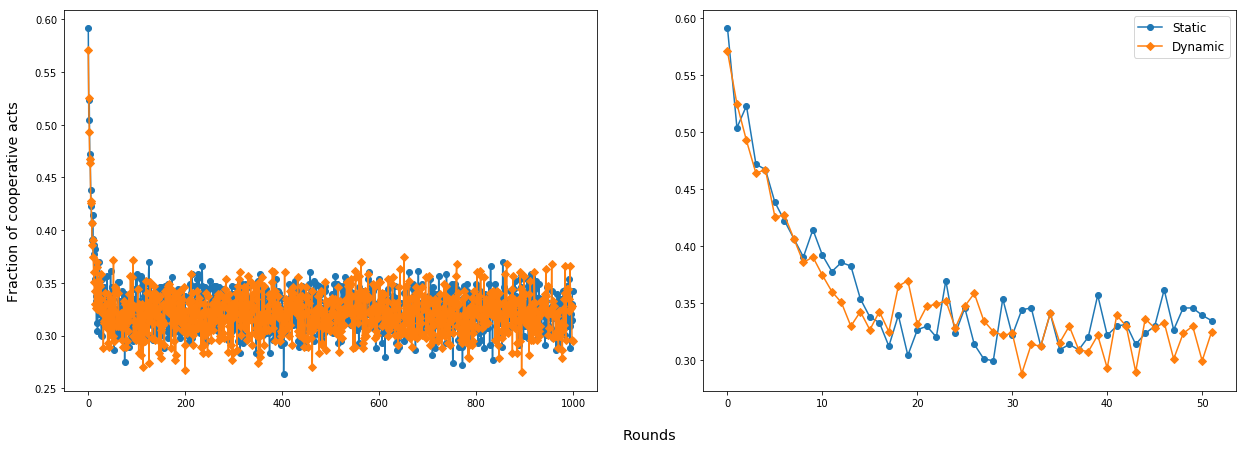

In [11]:
# create figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(21,7))

# plot the cooperation level
time = np.arange(n)
ax1.plot(time, cooperation_stat, marker = "o", label='Static')
ax1.plot(time, cooperation_dyn, marker = "D", label='Dynamic')
# ax1.plot(time, cooperation_rand, marker = "*", label='Random')

ax2.plot(time[0:52], cooperation_stat[0:52], marker = "o", label='Static')
ax2.plot(time[0:52], cooperation_dyn[0:52], marker = "D", label='Dynamic')
# ax2.plot(time[0:52], cooperation_rand[0:52], marker = "*", label='Random')
ax2.legend(fontsize='large')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Rounds', fontsize='x-large', labelpad=20)
plt.ylabel('Fraction of cooperative acts', fontsize='x-large', labelpad=20)

plt.show()
fig.savefig('plots/cooperation.png')

### Fraction of agents that reached a certain probability of cooperation 

In [12]:
def myHist(bins, P):
    ys = [0 for _ in bins]
    for i, val in enumerate(bins):
        for p in P:
            if p >= val - 0.05 and p < val + 0.05:
                ys[i] += 1
    res = [float(ysi)/N for ysi in ys]
    return res

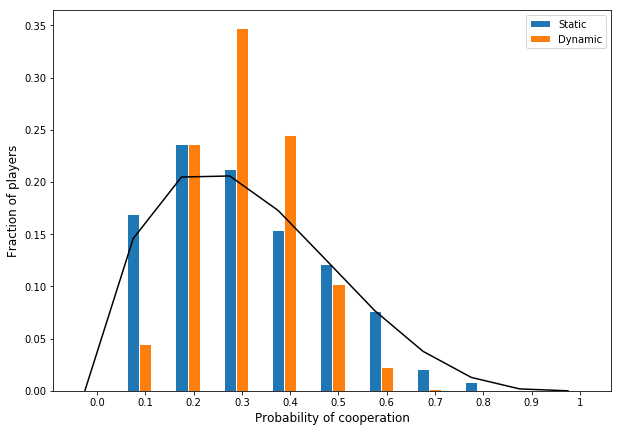

In [13]:
# Compute bar heights
xs = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
mu = [2*x*((1-x)**3) for x in xs]
bars1 = myHist(xs, P_tp1_stat)
bars2 = myHist(xs, P_tp1_dyn)
# bars3 = myHist(xs, P_tp1_rand)

# Set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(xs))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(r1, bars1, width=barWidth, edgecolor='white', label='Static')
ax.bar(r2, bars2, width=barWidth, edgecolor='white', label='Dynamic')
# ax.bar(r3, bars3, width=barWidth, edgecolor='white', label='var3')
ax.plot(r1, mu, c='k')

# Add xticks on the middle of the group bars
plt.xlabel('Probability of cooperation', fontsize='large')
plt.ylabel('Fraction of players', fontsize='large')
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
 
# Create legend & Show graphic
plt.legend()
plt.show()

fig.savefig('plots/prob_cooperation.png')

### Probability for a generic agent to cooperate after she cooperated or after she defected

### Stationary state: Probability of agents who reached a given probability of cooperation, a certain individual drive and a given normative drive

In [14]:
def plotStationaryState(P, dI, dN, filename):
    # create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey= True, figsize=(21,7))

    # plot the cooperation level
    bins = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    bars = myHist(bins, P)    
    ax1.bar(np.arange(len(bins)), bars, width = 0.5, color='#0504aa',alpha=0.7)
    ax1.set_xlabel('Probability of cooperation', fontsize='large')
    ax1.set_ylabel('Fraction of players', fontsize='large')
    ax1.set_ylim(0,1)
    
    # plot the individual drive
    hist,bin_edges = np.histogram(dI[:,52], bins = 5)
    ax2.bar(bin_edges[:-1], np.divide(hist,N), width = 0.5, color='#0504aa',alpha=0.7)
    ax2.set_xlabel('Individual drive', fontsize='large')
    ax2.set_ylabel('Fraction of players', fontsize='large')
    ax2.set_xlim(-16,0)
    
    # plot the normative drive
    hist,bin_edges = np.histogram(dN[:,52], bins = 5)
    ax3.bar(bin_edges[:-1], np.divide(hist,N), width = 0.5, color='#0504aa',alpha=0.7)
    ax3.set_xlabel('Normative drive', fontsize='large')
    ax3.set_ylabel('Fraction of players', fontsize='large')
    ax3.set_xlim(-5,30)

    plt.show()
    fig.savefig(filename)

*** Static lattice ***


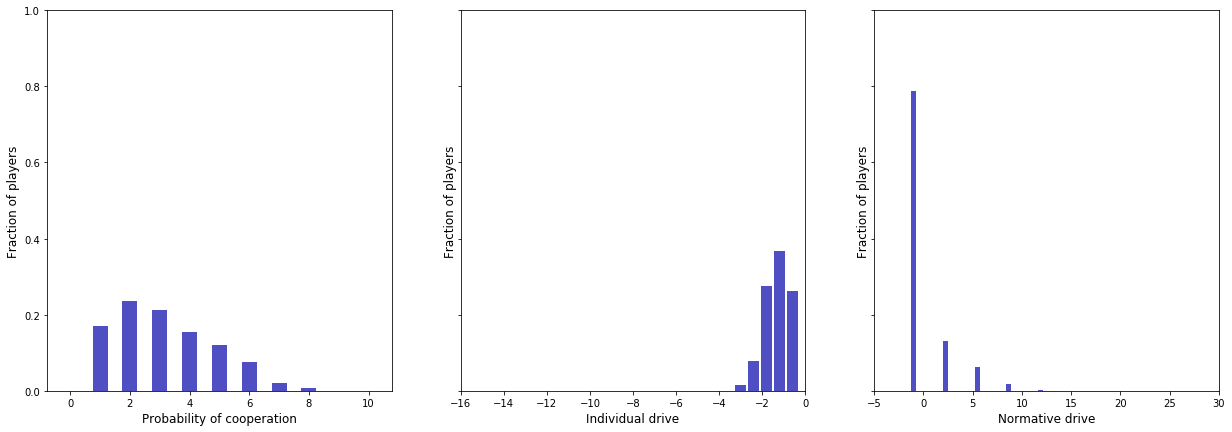

*** Dynamic lattice ***


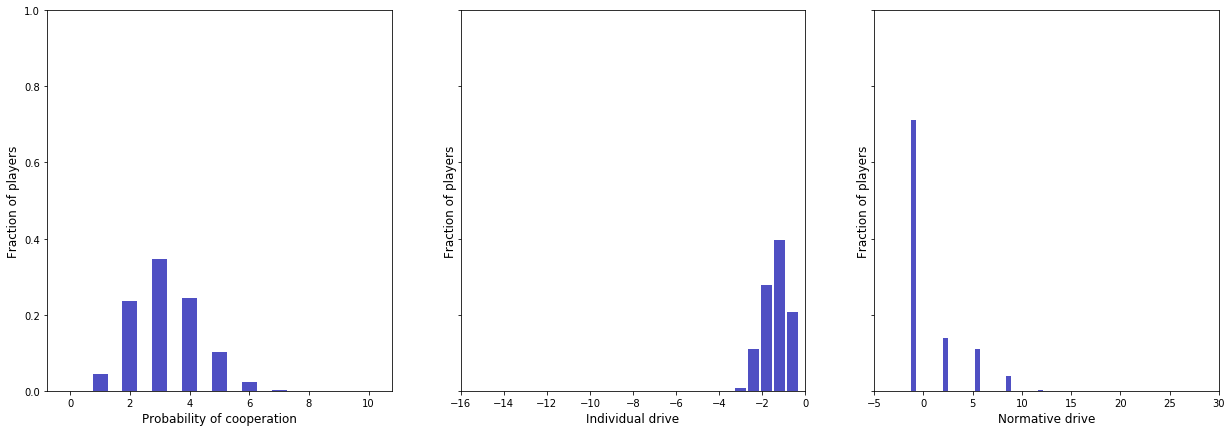

In [15]:
# plot for static lattice treatment
print('*** Static lattice ***')
plotStationaryState(P_tp1_stat, dI_stat, dN_stat, 'plots/stationary_static.png')

# plot for dynamic lattice treatment
print('*** Dynamic lattice ***')
plotStationaryState(P_tp1_dyn, dI_dyn, dN_dyn, 'plots/stationary_dyn.png')